In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file input already exists.
Error occurred while processing: input.


A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file outputs already exists.
Error occurred while processing: outputs.


# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [8]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002,betas=(0.5,0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002,betas=(0.5,0.999))

In [9]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [10]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [11]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [12]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [13]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [14]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

In [15]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    # return criterion(output, true_label)
    return criterion(output, true_label)
    
    
    ######################################
    
def discriminator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    return criterion(output, true_label)
    
    
    ######################################
    

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 
        x = data[0]

        ### UPDATE DISCRIMINATOR ###
        optim_d.zero_grad() # initialize gradient

        # real pass
        real_output = discriminator(x)
        d_loss_real = discriminator_loss(real_output, label_real(real_output.size()[0]))
        d_loss_real.backward()

        # fake pass
        fake_data = generator(create_noise(sample_size, nz))
        fake_output = discriminator(fake_data)
        d_loss_fake = discriminator_loss(fake_output, label_fake(sample_size))
        d_loss_fake.backward()

        # loss_D = (d_loss_real + d_loss_fake) / 2
        # loss_D.backward()
        optim_d.step()

        # loss_d += loss_D.detach().numpy()
        loss_d += d_loss_real.item() + d_loss_fake.item()

        ### UPDATE GENERATOR ###
        optim_g.zero_grad() # initialize gradient

        generated_data = generator(create_noise(sample_size, nz))
        generated_output = discriminator(generated_data)
        loss_G = generator_loss(generated_output, label_real(sample_size)) # we want to trick the discriminator on this pass

        loss_G.backward()
        optim_g.step()

        # loss_g += loss_G.detach().numpy()
        loss_g += loss_G.item()
    
        ######################################
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    # if (epoch + 1) % 5 == 0:
    #     plt.imshow(generated_img.permute(1, 2, 0))
    #     plt.title(f'epoch {epoch+1}')
    #     plt.axis('off')
    #     plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:21,  5.44it/s]                         


Epoch 1 of 100
Generator loss: 0.89233431, Discriminator loss: 1.21344539


118it [00:22,  5.18it/s]                         


Epoch 2 of 100
Generator loss: 1.51508693, Discriminator loss: 0.80018493


118it [00:28,  4.12it/s]                         


Epoch 3 of 100
Generator loss: 2.57623989, Discriminator loss: 0.60748687


118it [00:28,  4.08it/s]                         


Epoch 4 of 100
Generator loss: 3.10700087, Discriminator loss: 0.56760097


118it [00:24,  4.75it/s]                         


Epoch 5 of 100
Generator loss: 3.38156862, Discriminator loss: 0.63911728


118it [00:26,  4.49it/s]                         


Epoch 6 of 100
Generator loss: 3.39346600, Discriminator loss: 0.57983313


118it [00:24,  4.88it/s]                         


Epoch 7 of 100
Generator loss: 3.40839900, Discriminator loss: 0.57603893


118it [00:24,  4.76it/s]                         


Epoch 8 of 100
Generator loss: 3.16496424, Discriminator loss: 0.62582696


118it [00:26,  4.53it/s]                         


Epoch 9 of 100
Generator loss: 3.13270225, Discriminator loss: 0.60029280


118it [00:22,  5.32it/s]                         


Epoch 10 of 100
Generator loss: 3.72435599, Discriminator loss: 0.42099568


118it [00:22,  5.32it/s]                         


Epoch 11 of 100
Generator loss: 3.72008466, Discriminator loss: 0.48486457


118it [00:22,  5.36it/s]                         


Epoch 12 of 100
Generator loss: 3.34511882, Discriminator loss: 0.45234268


118it [00:21,  5.37it/s]                         


Epoch 13 of 100
Generator loss: 3.37860875, Discriminator loss: 0.48890289


118it [00:22,  5.35it/s]                         


Epoch 14 of 100
Generator loss: 3.03140165, Discriminator loss: 0.55070614


118it [00:22,  5.36it/s]                         


Epoch 15 of 100
Generator loss: 3.09468642, Discriminator loss: 0.46424356


118it [00:21,  5.40it/s]                         


Epoch 16 of 100
Generator loss: 3.15281580, Discriminator loss: 0.36138126


118it [00:21,  5.40it/s]                         


Epoch 17 of 100
Generator loss: 2.99566414, Discriminator loss: 0.35367088


118it [00:22,  5.36it/s]                         


Epoch 18 of 100
Generator loss: 2.98920418, Discriminator loss: 0.36099387


118it [00:22,  5.35it/s]                         


Epoch 19 of 100
Generator loss: 3.03096411, Discriminator loss: 0.36841094


118it [00:23,  5.03it/s]                         


Epoch 20 of 100
Generator loss: 2.94286393, Discriminator loss: 0.33076372


118it [00:24,  4.85it/s]                         


Epoch 21 of 100
Generator loss: 2.98633715, Discriminator loss: 0.34647985


118it [00:22,  5.22it/s]                         


Epoch 22 of 100
Generator loss: 2.83965758, Discriminator loss: 0.40250333


118it [00:22,  5.25it/s]                         


Epoch 23 of 100
Generator loss: 2.71199918, Discriminator loss: 0.42603354


118it [00:22,  5.27it/s]                         


Epoch 24 of 100
Generator loss: 2.58012214, Discriminator loss: 0.46551912


118it [00:25,  4.55it/s]                         


Epoch 25 of 100
Generator loss: 2.45036890, Discriminator loss: 0.50648787


118it [00:23,  4.95it/s]                         


Epoch 26 of 100
Generator loss: 2.41153055, Discriminator loss: 0.52529246


118it [00:22,  5.24it/s]                         


Epoch 27 of 100
Generator loss: 2.36411245, Discriminator loss: 0.52114117


118it [00:22,  5.25it/s]                         


Epoch 28 of 100
Generator loss: 2.29258940, Discriminator loss: 0.61361109


118it [00:25,  4.55it/s]                         


Epoch 29 of 100
Generator loss: 2.22686949, Discriminator loss: 0.60302456


118it [00:23,  5.07it/s]                         


Epoch 30 of 100
Generator loss: 2.13979986, Discriminator loss: 0.66952474


118it [00:22,  5.27it/s]                         


Epoch 31 of 100
Generator loss: 2.05574288, Discriminator loss: 0.69716041


118it [00:22,  5.22it/s]                         


Epoch 32 of 100
Generator loss: 1.99202017, Discriminator loss: 0.70046395


118it [00:22,  5.28it/s]                         


Epoch 33 of 100
Generator loss: 2.02642933, Discriminator loss: 0.70523105


118it [00:24,  4.86it/s]                         


Epoch 34 of 100
Generator loss: 2.04642163, Discriminator loss: 0.69000542


118it [00:22,  5.31it/s]                         


Epoch 35 of 100
Generator loss: 2.05895000, Discriminator loss: 0.70150603


118it [00:22,  5.33it/s]                         


Epoch 36 of 100
Generator loss: 2.00070626, Discriminator loss: 0.72214012


118it [00:22,  5.35it/s]                         


Epoch 37 of 100
Generator loss: 2.07180620, Discriminator loss: 0.67736482


118it [00:22,  5.25it/s]                         


Epoch 38 of 100
Generator loss: 1.99152974, Discriminator loss: 0.71399385


118it [00:21,  5.39it/s]                         


Epoch 39 of 100
Generator loss: 1.95386147, Discriminator loss: 0.72824327


118it [00:21,  5.39it/s]                         


Epoch 40 of 100
Generator loss: 1.93761626, Discriminator loss: 0.71283562


118it [00:22,  5.21it/s]                         


Epoch 41 of 100
Generator loss: 1.94291955, Discriminator loss: 0.71932507


118it [00:21,  5.40it/s]                         


Epoch 42 of 100
Generator loss: 1.92840281, Discriminator loss: 0.71938275


118it [00:22,  5.34it/s]                         


Epoch 43 of 100
Generator loss: 1.90660114, Discriminator loss: 0.71734198


118it [00:21,  5.38it/s]                         


Epoch 44 of 100
Generator loss: 1.77763409, Discriminator loss: 0.77622649


118it [00:21,  5.40it/s]                         


Epoch 45 of 100
Generator loss: 1.75386907, Discriminator loss: 0.79112470


118it [00:22,  5.35it/s]                         


Epoch 46 of 100
Generator loss: 1.81372272, Discriminator loss: 0.77026190


118it [00:21,  5.40it/s]                         


Epoch 47 of 100
Generator loss: 1.74393080, Discriminator loss: 0.80526546


118it [00:21,  5.37it/s]                         


Epoch 48 of 100
Generator loss: 1.66839369, Discriminator loss: 0.81753920


118it [00:21,  5.37it/s]                         


Epoch 49 of 100
Generator loss: 1.71521196, Discriminator loss: 0.82347169


118it [00:25,  4.60it/s]                         


Epoch 50 of 100
Generator loss: 1.68646187, Discriminator loss: 0.82383290


118it [00:26,  4.41it/s]                         


Epoch 51 of 100
Generator loss: 1.65603752, Discriminator loss: 0.84499193


118it [00:25,  4.54it/s]                         


Epoch 52 of 100
Generator loss: 1.62368114, Discriminator loss: 0.85223950


118it [00:25,  4.67it/s]                         


Epoch 53 of 100
Generator loss: 1.55585768, Discriminator loss: 0.89431892


118it [00:25,  4.65it/s]                         


Epoch 54 of 100
Generator loss: 1.59321513, Discriminator loss: 0.88365322


118it [00:25,  4.67it/s]                         


Epoch 55 of 100
Generator loss: 1.60118935, Discriminator loss: 0.89448089


118it [00:25,  4.67it/s]                         


Epoch 56 of 100
Generator loss: 1.57526695, Discriminator loss: 0.88796601


118it [00:25,  4.69it/s]                         


Epoch 57 of 100
Generator loss: 1.62836117, Discriminator loss: 0.86869409


118it [00:29,  4.03it/s]                         


Epoch 58 of 100
Generator loss: 1.56424481, Discriminator loss: 0.90864033


118it [00:27,  4.28it/s]                         


Epoch 59 of 100
Generator loss: 1.58526596, Discriminator loss: 0.87613403


118it [00:28,  4.17it/s]                         


Epoch 60 of 100
Generator loss: 1.52161574, Discriminator loss: 0.91021602


118it [00:26,  4.38it/s]                         


Epoch 61 of 100
Generator loss: 1.51836001, Discriminator loss: 0.91460216


118it [00:25,  4.67it/s]                         


Epoch 62 of 100
Generator loss: 1.52771683, Discriminator loss: 0.91601816


118it [00:24,  4.84it/s]                         


Epoch 63 of 100
Generator loss: 1.55184626, Discriminator loss: 0.90790288


118it [00:23,  4.99it/s]                         


Epoch 64 of 100
Generator loss: 1.51838174, Discriminator loss: 0.91162333


118it [00:25,  4.67it/s]                         


Epoch 65 of 100
Generator loss: 1.54813432, Discriminator loss: 0.90119194


118it [00:26,  4.42it/s]                         


Epoch 66 of 100
Generator loss: 1.59452512, Discriminator loss: 0.89543752


118it [00:24,  4.73it/s]                         


Epoch 67 of 100
Generator loss: 1.55837267, Discriminator loss: 0.90915580


118it [00:24,  4.83it/s]                         


Epoch 68 of 100
Generator loss: 1.53145211, Discriminator loss: 0.91264296


118it [00:24,  4.86it/s]                         


Epoch 69 of 100
Generator loss: 1.52301974, Discriminator loss: 0.91983768


118it [00:24,  4.87it/s]                         


Epoch 70 of 100
Generator loss: 1.54421294, Discriminator loss: 0.89149651


118it [00:26,  4.48it/s]                         


Epoch 71 of 100
Generator loss: 1.57269332, Discriminator loss: 0.89512495


118it [00:27,  4.27it/s]                         


Epoch 72 of 100
Generator loss: 1.53277545, Discriminator loss: 0.91472891


118it [00:31,  3.76it/s]                         


Epoch 73 of 100
Generator loss: 1.48078786, Discriminator loss: 0.93550708


118it [00:25,  4.68it/s]                         


Epoch 74 of 100
Generator loss: 1.49389724, Discriminator loss: 0.92044977


118it [00:25,  4.61it/s]                         


Epoch 75 of 100
Generator loss: 1.50201782, Discriminator loss: 0.93656620


118it [00:24,  4.73it/s]                         


Epoch 76 of 100
Generator loss: 1.49686191, Discriminator loss: 0.92345280


118it [00:25,  4.63it/s]                         


Epoch 77 of 100
Generator loss: 1.48998355, Discriminator loss: 0.93137390


118it [00:25,  4.57it/s]                         


Epoch 78 of 100
Generator loss: 1.46482457, Discriminator loss: 0.95430436


118it [00:29,  4.04it/s]                         


Epoch 79 of 100
Generator loss: 1.44150949, Discriminator loss: 0.95308710


118it [00:27,  4.24it/s]                         


Epoch 80 of 100
Generator loss: 1.46326796, Discriminator loss: 0.92909782


118it [00:24,  4.75it/s]                         


Epoch 81 of 100
Generator loss: 1.46234879, Discriminator loss: 0.94469263


118it [00:25,  4.59it/s]                         


Epoch 82 of 100
Generator loss: 1.46724195, Discriminator loss: 0.93962512


118it [00:23,  5.02it/s]                         


Epoch 83 of 100
Generator loss: 1.42198136, Discriminator loss: 0.96211639


118it [00:23,  4.98it/s]                         


Epoch 84 of 100
Generator loss: 1.42722088, Discriminator loss: 0.95936511


118it [00:25,  4.55it/s]                         


Epoch 85 of 100
Generator loss: 1.40960123, Discriminator loss: 0.96557617


118it [00:24,  4.74it/s]                         


Epoch 86 of 100
Generator loss: 1.41691896, Discriminator loss: 0.97293112


118it [00:23,  4.95it/s]                         


Epoch 87 of 100
Generator loss: 1.37999171, Discriminator loss: 0.97815017


118it [00:23,  5.00it/s]                         


Epoch 88 of 100
Generator loss: 1.43002717, Discriminator loss: 0.95671900


118it [00:23,  5.10it/s]                         


Epoch 89 of 100
Generator loss: 1.39904070, Discriminator loss: 0.97419283


118it [00:27,  4.36it/s]                         


Epoch 90 of 100
Generator loss: 1.41083335, Discriminator loss: 0.96994813


118it [00:25,  4.66it/s]                         


Epoch 91 of 100
Generator loss: 1.41515271, Discriminator loss: 0.96993881


118it [00:23,  5.02it/s]                         


Epoch 92 of 100
Generator loss: 1.39114712, Discriminator loss: 0.97714430


118it [00:23,  4.97it/s]                         


Epoch 93 of 100
Generator loss: 1.37084920, Discriminator loss: 0.97657584


118it [00:23,  5.02it/s]                         


Epoch 94 of 100
Generator loss: 1.38915571, Discriminator loss: 0.98580016


118it [00:23,  5.02it/s]                         


Epoch 95 of 100
Generator loss: 1.37325205, Discriminator loss: 0.98559688


118it [00:22,  5.20it/s]                         


Epoch 96 of 100
Generator loss: 1.36980436, Discriminator loss: 0.99146896


118it [00:22,  5.27it/s]                         


Epoch 97 of 100
Generator loss: 1.38177992, Discriminator loss: 0.98015804


118it [00:23,  5.00it/s]                         


Epoch 98 of 100
Generator loss: 1.38730154, Discriminator loss: 0.98014543


118it [00:23,  4.93it/s]                         


Epoch 99 of 100
Generator loss: 1.38026452, Discriminator loss: 0.98306672


118it [00:24,  4.89it/s]                         

Epoch 100 of 100
Generator loss: 1.36594954, Discriminator loss: 1.00223202


In [16]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [17]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

np.savetxt("Generator loss.txt", np.array(losses_g))
np.savetxt("Discriminator loss.txt", np.array(losses_d))

In [ ]:
# # plot and save the generator and discriminator loss
# plt.figure()
# plt.plot(losses_g, label='Generator loss')
# plt.plot(losses_d, label='Discriminator Loss')
# plt.legend()
# plt.savefig('outputs/loss.png')

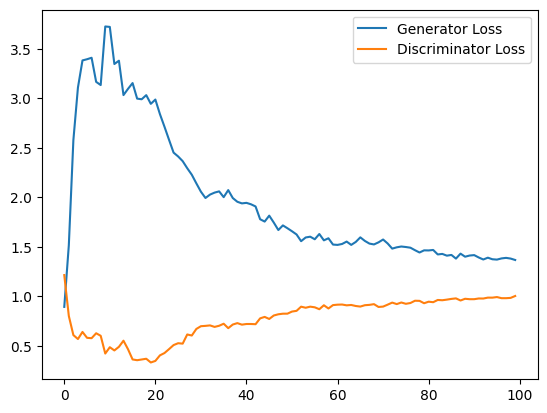

In [2]:
import numpy as np
import matplotlib.pyplot as plt

disc = np.loadtxt("./Discriminator loss.txt")
gen = np.loadtxt("./Generator loss.txt")

plt.plot(gen, label='Generator Loss')
plt.plot(disc, label='Discriminator Loss')
plt.legend()